In [1]:
# Import Modules
import os
import time, gc
import numpy as np
import pandas as pd
from math import ceil
import cv2
import tensorflow as tf

# Keras
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint

# Iterative-Stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

# Custom 
from preprocessing import generate_images, resize_image
from model import create_model
from utils import plot_summaries

Using TensorFlow backend.


In [14]:
# Seeds
# SEED = 1234
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

# Input Dir
DATA_DIR = '/home/jupyter'
TRAIN_DIR = '/home/jupyter/train/'

# Constants
HEIGHT = 137
WIDTH = 236
SCALE_FACTOR = 0.8
HEIGHT_NEW = int(HEIGHT * SCALE_FACTOR)
WIDTH_NEW = int(WIDTH * SCALE_FACTOR)
RUN_NAME = 'Train1_'
PLOT_NAME1 = 'Train1_LossAndAccuracy.png'
#PLOT_NAME2 = 'Train1_Recall.png'

BATCH_SIZE = 112
CHANNELS = 3
EPOCHS = 40
TEST_SIZE = 1./6

# Image Size Summary
print(HEIGHT_NEW)
print(WIDTH_NEW)

109
188


In [4]:
GENERATE_IMAGES = True
if GENERATE_IMAGES:
    generate_images(DATA_DIR, TRAIN_DIR, WIDTH, HEIGHT, WIDTH_NEW, HEIGHT_NEW)

In [5]:
# Prepare Train Labels (Y)
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
tgt_cols = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
desc_df = train_df[tgt_cols].astype('str').describe()
types = desc_df.loc['unique',:]
X_train = train_df['image_id'].values
train_df = train_df[tgt_cols].astype('uint8')
for col in tgt_cols:
    train_df[col] = train_df[col].map('{:03}'.format)
Y_train = pd.get_dummies(train_df)

# Cleanup
del train_df
gc.collect()

3

In [5]:
len(X_train)

200840

In [16]:
# Modelcheckpoint
def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = False, 
                            save_weights_only = True, 
                            mode = 'min', 
                            period = 1)


def _read(path):
    img = cv2.imread(path)    
    return img

class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, X_set, Y_set, ids, batch_size = 16, img_size = (512, 512, 3), img_dir = TRAIN_DIR, *args, **kwargs):
        self.X = X_set
        self.ids = ids
        self.Y = Y_set
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

        # Split Data
        self.x_indexed = self.X[self.ids]
        self.y_indexed = self.Y.iloc[self.ids]

        # Prep Y per Label   
        self.y_root = self.y_indexed.iloc[:,0:types['grapheme_root']]
        self.y_vowel = self.y_indexed.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
        self.y_consonant = self.y_indexed.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y_root, Y_vowel, Y_consonant = self.__data_generation(indices)
        return X, {'root': Y_root, 'vowel': Y_vowel, 'consonant': Y_consonant}

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y_root = np.empty((self.batch_size, 168), dtype = np.int16)
        Y_vowel = np.empty((self.batch_size, 11), dtype = np.int16)
        Y_consonant = np.empty((self.batch_size, 7), dtype = np.int16)

        for i, index in enumerate(indices):
            ID = self.x_indexed[index]
            image = _read(self.img_dir+ID+".png")
            
            X[i,] = image
            
            Y_root[i,] = self.y_root.iloc[index].values
            Y_vowel[i,] = self.y_vowel.iloc[index].values
            Y_consonant[i,] = self.y_consonant.iloc[index].values    
       
        return X, Y_root, Y_vowel, Y_consonant 

# Create Model
model = create_model(input_shape = (HEIGHT_NEW, WIDTH_NEW, CHANNELS))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.00016,
    decay_steps = s,
    decay_rate=0.96,
    staircase=True)

# Compile Model
model.compile(optimizer = Adam(lr = 0.00016),
                loss = {'root': 'categorical_crossentropy',
                        'vowel': 'categorical_crossentropy',
                        'consonant': 'categorical_crossentropy'},
                loss_weights = {'root': 0.50,        
                                'vowel': 0.25,
                                'consonant': 0.25},
                metrics = {'root': ['accuracy', tf.keras.metrics.Recall()],
                            'vowel': ['accuracy', tf.keras.metrics.Recall()],
                            'consonant': ['accuracy', tf.keras.metrics.Recall()] })

# Model Summary
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 109, 188, 3)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 55, 94, 40)   1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 55, 94, 40)   160         conv2d_105[0][0]                 
__________________________________________________________________________________________________
swish_79 (Swish)                (None, 55, 94, 40)   0           batch_normalization_79[0][0]     
____________________________________________________________________________________________

In [17]:
# Multi Label Stratified Split stuff...
msss = MultilabelStratifiedShuffleSplit(n_splits = EPOCHS, test_size = TEST_SIZE)

# CustomReduceLRonPlateau function
best_val_loss = np.Inf
def CustomReduceLRonPlateau(model, history, epoch):
    global best_val_loss
    
    # ReduceLR Constants
    monitor = 'val_root_loss'
    patience = 5
    factor = 0.75
    min_lr = 1e-5

    # Get Current LR
    current_lr = float(K.get_value(model.optimizer.lr))
    
    # Print Current Learning Rate
    print('Current LR: {0}'.format(current_lr))

    # Monitor Best Value
    current_val_loss = history[monitor][-1]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
    print('Best Vall Loss: {0}'.format(best_val_loss))

    # Track last values
    if len(history[monitor]) >= patience:
        last5 = history[monitor][-5:]
        print('Last: {0}'.format(last5))
        best_in_last = min(last5)
        print('Min value in Last: {0}'.format(best_in_last))

        # Determine correction
        if best_val_loss < best_in_last:
            new_lr = current_lr * factor
            if new_lr < min_lr:
                new_lr = min_lr
            print('ReduceLRonPlateau setting learning rate to: {0}'.format(new_lr))
            K.set_value(model.optimizer.lr, new_lr)

=========== EPOCH 0
Train Length: 167367   First 10 indices: [160621  59117 128874 168211 192546 138780 167057  39790 110152 147779]
Valid Length: 33473    First 10 indices: [ 2 34 36 39 41 51 52 61 86 91]
Train Generator Size: 1495
Validation Generator Size: 299
Epoch 1/1
1495/1495 [==============================] - 1436s 961ms/step - loss: 2.0355 - root_loss: 3.1032 - vowel_loss: 1.6131 - consonant_loss: 0.3226 - root_accuracy: 0.6039 - root_recall_3: 0.2941 - vowel_accuracy: 0.8235 - vowel_recall_4: 0.6223 - consonant_accuracy: 0.8932 - consonant_recall_5: 0.7682 - val_loss: 1.7766 - val_root_loss: 1.0324 - val_vowel_loss: 0.4343 - val_consonant_loss: 0.1789 - val_root_accuracy: 0.7633 - val_root_recall_3: 0.5067 - val_vowel_accuracy: 0.8891 - val_vowel_recall_4: 0.7826 - val_consonant_accuracy: 0.9427 - val_consonant_recall_5: 0.8826

Epoch 00001: saving model to Train1_model_0.h5
Current LR: 0.00015999999595806003
Best Vall Loss: 1.0323822498321533
=========== EPOCH 1
Train Length

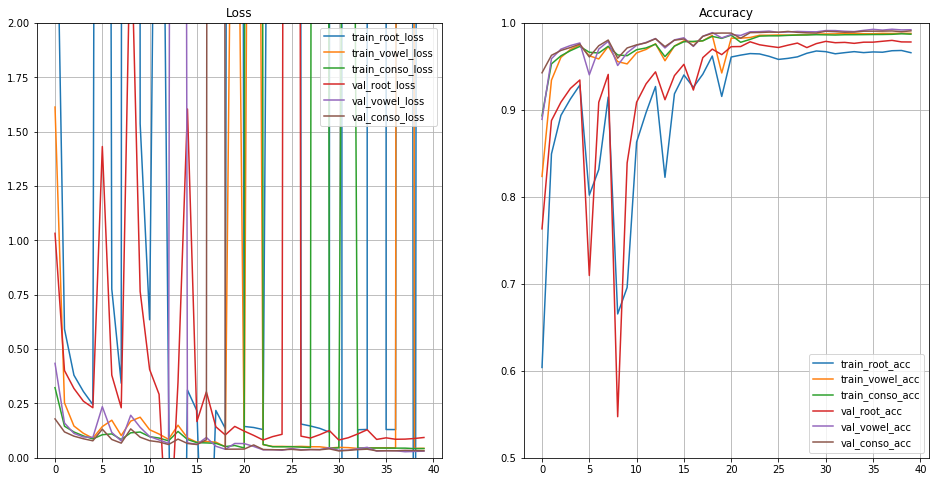

In [18]:
# History Placeholder
history = {}

# Epoch Training Loop
for epoch, msss_splits in zip(range(0, EPOCHS), msss.split(X_train, Y_train)):
    print('=========== EPOCH {}'.format(epoch))

    # Get train and test index, shuffle train indexes.
    train_idx = msss_splits[0]
    valid_idx = msss_splits[1]
    np.random.shuffle(train_idx)
    print('Train Length: {0}   First 10 indices: {1}'.format(len(train_idx), train_idx[:10]))    
    print('Valid Length: {0}    First 10 indices: {1}'.format(len(valid_idx), valid_idx[:10]))

    # Create Data Generators for Train and Valid
    data_generator_train = TrainDataGenerator(X_train, 
                                            Y_train,
                                            train_idx, 
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)
    data_generator_val = TrainDataGenerator(X_train, 
                                            Y_train,
                                            valid_idx,
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)

    TRAIN_STEPS = int(len(data_generator_train))
    VALID_STEPS = int(len(data_generator_val))
    print('Train Generator Size: {0}'.format(len(data_generator_train)))
    print('Validation Generator Size: {0}'.format(len(data_generator_val)))
    
    model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        validation_steps = VALID_STEPS,
                        epochs = 1,
                        callbacks = [ModelCheckpointFull(RUN_NAME + 'model_' + str(epoch) + '.h5')],
                        verbose = 1)

    # Set and Concat Training History
    temp_history = model.history.history
    if epoch == 0:
        history = temp_history
    else:
        for k in temp_history: history[k] = history[k] + temp_history[k]

    # Custom ReduceLRonPlateau
    CustomReduceLRonPlateau(model, history, epoch)

    # Cleanup
    del data_generator_train, data_generator_val, train_idx, valid_idx
    gc.collect()

# Plot Training Summaries
plot_summaries(history, PLOT_NAME1)

# Create Predictions
row_ids, targets = [], []
id = 0

# Loop through parquet files
for i in range(4):
    img_df = pd.read_parquet(os.path.join(DATA_DIR, 'test_image_data_'+str(i)+'.parquet'))
    img_df = img_df.drop('image_id', axis = 1)
    
    # Loop through rows in parquet file
    for index, row in img_df.iterrows():
        img = resize_image(row.values, WIDTH, HEIGHT, WIDTH_NEW, HEIGHT_NEW)
        img = np.stack((img,)*CHANNELS, axis=-1)
        image = img.reshape(-1, HEIGHT_NEW, WIDTH_NEW, 3)
        
        # Predict
        preds = model.predict(image, verbose = 1)
        for k in range(3):
            row_ids.append('Test_' + str(id) + '_' + tgt_cols[k])
            targets.append(np.argmax(preds[k]))
        id += 1


In [ ]:
for epoch, msss_splits in zip(range(0, 10), msss.split(X_train, Y_train)):
    print('=========== EPOCH {}'.format(epoch))

    # Get train and test index, shuffle train indexes.
    train_idx = msss_splits[0]
    valid_idx = msss_splits[1]
    np.random.shuffle(train_idx)
    print('Train Length: {0}   First 10 indices: {1}'.format(len(train_idx), train_idx[:10]))    
    print('Valid Length: {0}    First 10 indices: {1}'.format(len(valid_idx), valid_idx[:10]))

    # Create Data Generators for Train and Valid
    data_generator_train = TrainDataGenerator(X_train, 
                                            Y_train,
                                            train_idx, 
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)
    data_generator_val = TrainDataGenerator(X_train, 
                                            Y_train,
                                            valid_idx,
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)

    TRAIN_STEPS = int(len(data_generator_train))
    VALID_STEPS = int(len(data_generator_val))
    print('Train Generator Size: {0}'.format(len(data_generator_train)))
    print('Validation Generator Size: {0}'.format(len(data_generator_val)))
    
    model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        validation_steps = VALID_STEPS,
                        epochs = 1,
                        callbacks = [ModelCheckpointFull(RUN_NAME + 'model_' + str(epoch) + '.h5')],
                        verbose = 1)

    # Set and Concat Training History
    temp_history = model.history.history
    if epoch == 0:
        history = temp_history
    else:
        for k in temp_history: history[k] = history[k] + temp_history[k]

    # Custom ReduceLRonPlateau
    CustomReduceLRonPlateau(model, history, epoch)

    # Cleanup
    del data_generator_train, data_generator_val, train_idx, valid_idx
    gc.collect()

# Plot Training Summaries
plot_summaries(history, PLOT_NAME1)

=========== EPOCH 0
Train Length: 167366   First 10 indices: [ 78418  46471  79937 186088 128675 183648  28378 198755 180329 126392]
Valid Length: 33474    First 10 indices: [ 2  9 21 27 29 47 54 62 85 95]
Train Generator Size: 1495
Validation Generator Size: 299
Epoch 1/1
1495/1495 [==============================] - 1399s 936ms/step - loss: -176.4385 - root_loss: -352.9193 - vowel_loss: 0.0435 - consonant_loss: 0.0423 - root_accuracy: 0.9649 - root_recall_3: 0.8883 - vowel_accuracy: 0.9878 - vowel_recall_4: 0.9694 - consonant_accuracy: 0.9874 - consonant_recall_5: 0.9759 - val_loss: 1.1665 - val_root_loss: 0.0993 - val_vowel_loss: 0.0320 - val_consonant_loss: 0.0337 - val_root_accuracy: 0.9758 - val_root_recall_3: 0.8891 - val_vowel_accuracy: 0.9919 - val_vowel_recall_4: 0.9696 - val_consonant_accuracy: 0.9898 - val_consonant_recall_5: 0.9760

Epoch 00001: saving model to Train1_model_0.h5
Current LR: 9.999999747378752e-06
Best Vall Loss: -0.5091016888618469
=========== EPOCH 1
Train 

In [19]:
# Create and Save Submission File
submission = pd.DataFrame({'row_id': row_ids, 'target': targets}, columns = ['row_id', 'target'])
#submission.to_csv('submission.csv', index = False)
print(submission.head(25))

                        row_id  target
0         Test_0_grapheme_root       3
1       Test_0_vowel_diacritic       0
2   Test_0_consonant_diacritic       0
3         Test_1_grapheme_root      93
4       Test_1_vowel_diacritic       2
5   Test_1_consonant_diacritic       0
6         Test_2_grapheme_root      19
7       Test_2_vowel_diacritic       0
8   Test_2_consonant_diacritic       0
9         Test_3_grapheme_root     115
10      Test_3_vowel_diacritic       0
11  Test_3_consonant_diacritic       0
12        Test_4_grapheme_root      79
13      Test_4_vowel_diacritic       4
14  Test_4_consonant_diacritic       0
15        Test_5_grapheme_root     115
16      Test_5_vowel_diacritic       2
17  Test_5_consonant_diacritic       0
18        Test_6_grapheme_root     147
19      Test_6_vowel_diacritic       9
20  Test_6_consonant_diacritic       5
21        Test_7_grapheme_root     137
22      Test_7_vowel_diacritic       7
23  Test_7_consonant_diacritic       0
24        Test_8_grapheme